Q4. MFCC Extraction (From Scratch)

In [1]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

sampling_rate, signal = wavfile.read("testing_voice.wav")

if len(signal.shape) > 1:
    signal = signal[:, 0]

signal = signal.astype(float)


C:\Users\Apurbo\AppData\Local\Temp\ipykernel_6300\3188843573.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, signal = wavfile.read("testing_voice.wav")


(a) MFCC Steps Implementation

1️⃣ Pre-emphasis

In [2]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])


2️⃣ Framing (25 ms, 10 ms)

In [3]:
frame_size = int(0.025 * sampling_rate)
frame_shift = int(0.010 * sampling_rate)

signal_length = len(emphasized_signal)
num_frames = int(np.floor((signal_length - frame_size) / frame_shift)) + 1

frames = np.zeros((num_frames, frame_size))

for i in range(num_frames):
    start = i * frame_shift
    end = start + frame_size
    frames[i] = emphasized_signal[start:end]


3️⃣ Hamming Window

In [4]:
n = np.arange(frame_size)
hamming = 0.54 - 0.46 * np.cos((2 * np.pi * n) / (frame_size - 1))
frames *= hamming


4️⃣ FFT & Power Spectrum

In [5]:
NFFT = frame_size
mag_frames = np.abs(np.fft.rfft(frames, NFFT))
pow_frames = (1.0 / NFFT) * (mag_frames ** 2)


5️⃣ Mel Filterbank

In [6]:
num_filters = 26

low_freq_mel = 0
high_freq_mel = 2595 * np.log10(1 + (sampling_rate / 2) / 700)

mel_points = np.linspace(low_freq_mel, high_freq_mel, num_filters + 2)
hz_points = 700 * (10**(mel_points / 2595) - 1)

bin_points = np.floor((NFFT + 1) * hz_points / sampling_rate).astype(int)


Create Filterbank

In [7]:
fbank = np.zeros((num_filters, int(NFFT/2 + 1)))

for m in range(1, num_filters + 1):
    f_m_minus = bin_points[m - 1]
    f_m = bin_points[m]
    f_m_plus = bin_points[m + 1]

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - f_m_minus) / (f_m - f_m_minus)
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (f_m_plus - k) / (f_m_plus - f_m)


apply filterbanf:

In [8]:
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, 1e-10, filter_banks)
filter_banks = np.log(filter_banks)


6️⃣ DCT → Extract 13 MFCCs

In [9]:
from scipy.fftpack import dct

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, :13]

print("MFCC shape:", mfcc.shape)


MFCC shape: (2996, 13)


(b) Plot MFCC Heatmap

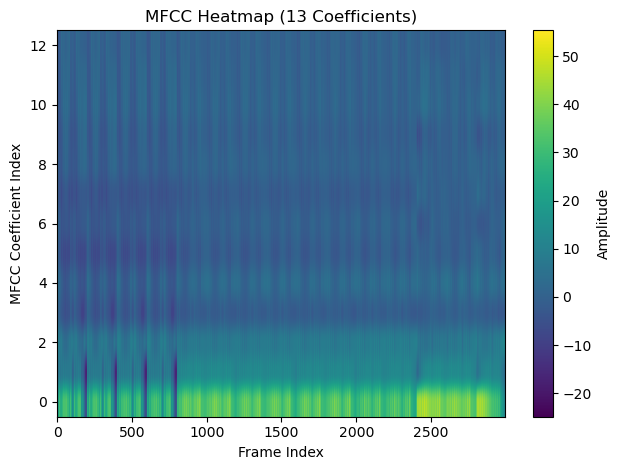

In [10]:
plt.figure()
plt.imshow(mfcc.T, aspect='auto', origin='lower')
plt.xlabel("Frame Index")
plt.ylabel("MFCC Coefficient Index")
plt.title("MFCC Heatmap (13 Coefficients)")
plt.colorbar(label="Amplitude")
plt.tight_layout()
plt.show()
